In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from utils import create_model
import os
from config import config
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-09-06 17:01:35.214528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 17:01:35.807189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# import cv2


# def crop_images_in_directory(input_dir, output_dir):
#     # Initialize the cropper
#     cropper = Cropper()

#     # Walk through the input directory
#     for dirpath, dirnames, filenames in os.walk(input_dir):
#         for filename in filenames:
#             # Check if the file is an image (based on the extension)
#             if filename.lower().endswith((".png", ".jpg", ".jpeg")):
#                 input_filepath = os.path.join(dirpath, filename)

#                 # Crop the image
#                 result = cropper.crop(input_filepath)

#                 # Create the corresponding output directory
#                 relative_path = os.path.relpath(dirpath, input_dir)
#                 output_folder_path = os.path.join(output_dir, relative_path)
#                 os.makedirs(output_folder_path, exist_ok=True)

#                 # Save the cropped image
#                 output_filepath = os.path.join(output_folder_path, filename)
#                 cv2.imwrite(output_filepath, result)


# # Usage
# input_folder = "Dataset/extracted/"
# output_folder = "Dataset/cropped"
# crop_images_in_directory(input_folder, output_folder)

# Quantitative Results

In [3]:
model_filename = "vgg16_2023-09-06 16:38:30.568754_e50_lr0.0001_bs16"
history = pd.read_csv(f"runs/{model_filename}.csv")

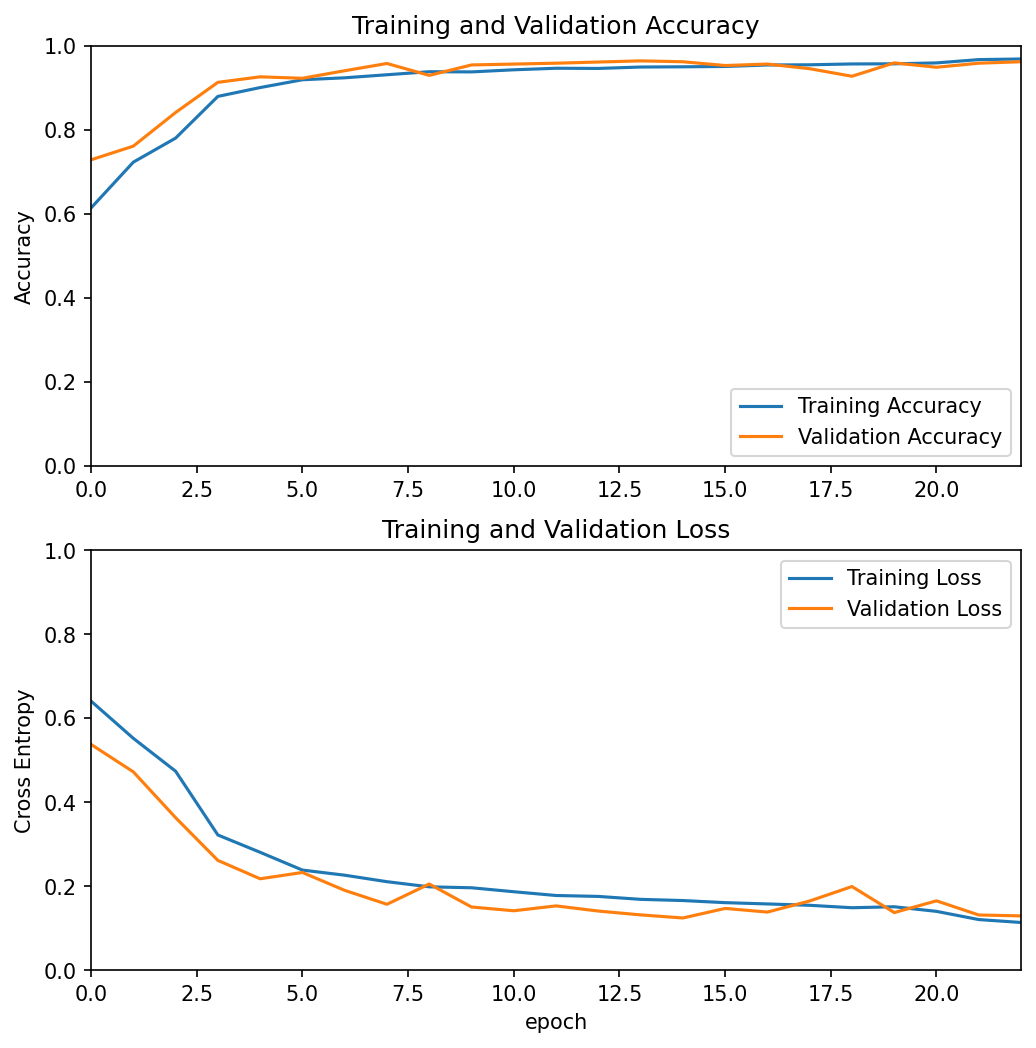

In [4]:
acc = history["accuracy"]
val_acc = history["val_accuracy"]

loss = history["loss"]
val_loss = history["val_loss"]

plt.figure(figsize=(8, 8), dpi=150)
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.xlim([0, len(history["accuracy"]) - 1])
plt.ylim([0, 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.xlim([0, len(history["accuracy"]) - 1])
plt.ylim([0, 1])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [5]:
test_set = tf.keras.utils.image_dataset_from_directory(
    "Dataset/cropped/test",
    seed=config["seed"],
    image_size=config["image_size"],
    batch_size=16,
    label_mode="binary",
)

AUTOTUNE = tf.data.AUTOTUNE
test_labels = np.concatenate([y for x, y in test_set], axis=0)
test_labels = list(test_labels.flatten().astype("uint8"))

Found 2458 files belonging to 2 classes.


2023-09-06 17:01:37.217205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13843 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
base_model = tf.keras.applications.vgg16.VGG16(
    weights=None, include_top=False, input_shape=(224, 224, 3)
)


model = create_model(base_model, config)
checkpoint_dir = f"checkpoints/{model_filename}"
latest_ckpt = tf.train.latest_checkpoint(checkpoint_dir)

print(latest_ckpt)
model.load_weights(latest_ckpt)

checkpoints/vgg16_2023-09-06 16:38:30.568754_e50_lr0.0001_bs16/cp-0015.ckpt


ValueError: Received incompatible tensor with shape (3, 3, 3, 64) when attempting to restore variable with shape (7, 7, 3, 64) and name conv1/conv/kernel:0.

In [ ]:
y_pred = model.predict(test_set)

2023-09-06 16:21:46.531905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-06 16:21:46.970829: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-06 16:21:47.043424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


154/154 [==============================] - 6s 25ms/step


In [ ]:
y_pred = y_pred.flatten()
y_pred = list(tf.where(y_pred < 0.5, 0, 1).numpy())

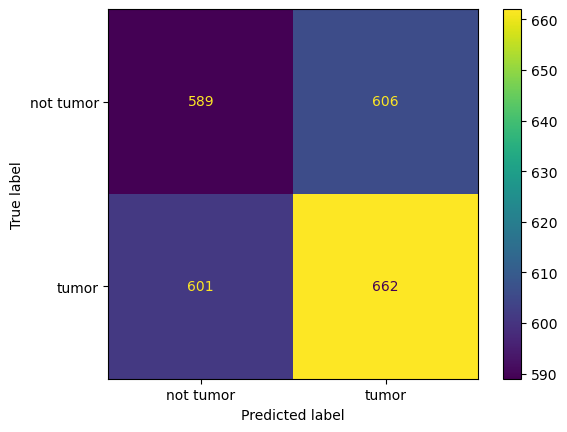

In [ ]:
class_names = ["not tumor", "tumor"]

cm = confusion_matrix(y_true=test_labels, y_pred=y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.scores import CategoricalScore

image_batch, label_batch = test_set.as_numpy_iterator().next()

# score = CategoricalScore(label_batch.flatten())
score = CategoricalScore(list(label_batch.flatten().astype("uint8")))

gradcam = GradcamPlusPlus(
    model.get_layer("vgg16"), model_modifier=ReplaceToLinear(), clone=True
)
cam = gradcam(score, image_batch, penultimate_layer=-1)

plt.figure(figsize=(15, 5))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    plt.imshow(heatmap, cmap="jet", alpha=0.3)

    misclassified = (
        class_names[y_pred[i].astype("uint8")]
        == class_names[label_batch[i][0].astype("uint8")]
    )

    color = "black" if misclassified else "red"
    plt.title(
        f"pred: {class_names[y_pred[i].astype('uint8')]}\n true: {class_names[label_batch[i][0].astype('uint8')]}",
        color=color,
    )
    plt.axis("off")

ValueError: Invalid index value. indices: [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1], output.shape: (16, 1)